# Python Neural Network Visualization

Neural Networks are complex and intricate systems, and understanding their inner workings can be a difficult learning curve. Thankfully, Python programming makes it easy to create neural networks and visualize their training process.

## Import Libraries

Before you get started, it's necessary to import all of the required modules for the project. Ensure all of these modules are installed in your Python environment and run the cell below:

In [1]:
%matplotlib widget
import math, random, os, time
from numpy import array, vstack, linspace
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from IPython.display import clear_output, display
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.inspection import DecisionBoundaryDisplay
from scikeras.wrappers import KerasClassifier
from tensorflow import get_logger, autograph, device
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from absl import logging
from tqdm.auto import tqdm

## Dataset Generation

With the necessary modules imported, you can now generate an example dataset.

A dataset is an array of data points called *samples*. Each sample consists of a set of values, called *features*, and an output value. During training, the neural network is given each features and asked to predict the output value. Each training iteration is called an *epoch*, and the *batch size* controls how many samples the model sees per epoch. After each epoch, the model uses an optimization function to adjust its weights to minimize the error between its output and the dataset.

Features can be thought of as single measurement points. For example, if you were creating a dataset to classify types of birds, one factor may be "beak length" and another may be "wingspan". The output could then be the corresponding breed of bird, like "Cardinal". In this case, each sample in your dataset would be formatted as: `[beak length, wingspan, breed]`. Indices 0 and 1 are the factors and index 2 is the output.

While there are numerous datasets available to download online, you can also generate datasets with code. For this demonstration, you will generate a dataset with two features (x and y coordinates) and a binary output, either a 1 or a 0. This type of problem, where there is a single binary output, is known as *binary classification*.

Below is code for generating two different types of datasets. The first generates a random binary classification problem, and the second generates a spiral pattern.

You can set how many samples to generate by adjusting the variable `samples` and the noise of the spiral data by adjusting `noise`: 

In [2]:
samples, noise = 5000, 0.3

# Visualize the decision boundary per epoch. Slow.
show_progress = True

Now, generate the dataset by calling either `classification_data(samples)` or `spiral_data(samples, noise)`:

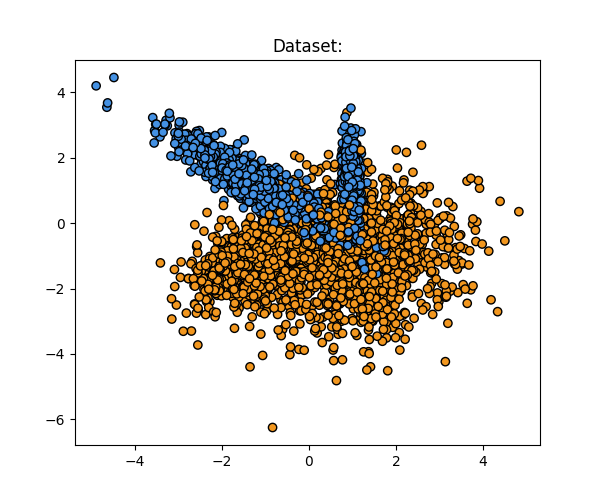

In [3]:
def classification_data(samples=2000):
    X, y = make_classification(samples, 2, n_informative=2, n_redundant=0)
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    return X, y, X_train, X_test, y_train, y_test

def spiral_data(samples=2000, noise=0.3):
    points = []
    n = samples/2
    def randUniform(a, b):
        return random.random() * (b - a) + a
    def genSpiral(deltaT, label):
        i = 0
        while i < n:
            r = i / n * 5
            t = 1.75 * i / n * 2 * math.pi + deltaT
            x = r * math.sin(t) + randUniform(-1, 1) * noise
            y = r * math.cos(t) + randUniform(-1, 1) * noise
            points.append([x, y, label])
            i = i + 1
    genSpiral(0, 1)
    genSpiral(math.pi, 0)
    X = array(points)[:,:2]
    y = array(points)[:,2]
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    return X, y, X_train, X_test, y_train, y_test

X, y, X_train, X_test, y_train, y_test = classification_data(samples) # <--- Call either classification_data(samples) or spiral_data(samples, noise)

# Create a colormap for the output colors
newcolors = vstack((linspace((242/255, 151/255, 31/255), (1, 1, 1)), linspace((1, 1, 1), (68/255, 145/255, 227/255))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

# Visualize the dataset
datafig, dataax = plt.subplots(figsize=(6,5))
dataax.scatter(X[:,0], X[:,1], c=y, cmap=newcmp, marker='o', edgecolors="black")
dataax.set_title("Dataset:")
display(plt.gcf())
clear_output(wait=True)

## Creating the Model

Now that you've created a dataset, you need to create a neural network to train on the data.

Firstly, surpress info messages from Tensorflow and absl. You can always change this later if you need more verbosity.

In [4]:
# Set all logging to error level
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'}
get_logger().setLevel('ERROR')
autograph.set_verbosity(0)
logging.set_verbosity(logging.ERROR)

Next, define a function to create the model. This is where you define the model's layers and nodes, as well as the loss function and optimizer.

In [5]:
# Function for creating the model called by KerasClassifier()
def create_model(learning_rate=0.01):
    # Define the Keras model
    model = Sequential()

    # Add some layers and nodes
    model.add(Dense(8, input_shape=(2,), activation="relu"))
    model.add(Dense(8, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    
    # Compile the Keras model
    opt = Adam(learning_rate=learning_rate)
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
    
    return model

Now create an instance of the model wrapped in a KerasClassifer object. Additionally, a callback to print the training progress and visualize the model is created.

In [6]:
# Create a callback to visualize progress
class ShowDisplayBound(Callback):
    # Runs at the end of each epoch
    def on_epoch_end(self, epoch, logs=None):
        if epoch%5 == 0:
            # Get the model's prediction using the test data
            predicted_y = pipeline.predict(X_test)
            difference = differences(y_test, predicted_y)
            accuracy = (samples/4 - difference) / (samples/4) * 100
            # Print progress bar and accuracy
            display(f"{tqdm.format_meter(epoch, epochnum, time.time() - t_start)} Accuracy: {round(accuracy, 2)}%")
            if show_progress == False:
                clear_output(wait=True)
            # If show_progress is True, visualize the model's decision boundary for each epoch
            # The decision boundary shows the model's prediction probability for a 100x100 grid over the domain of the dataset
            if show_progress == True:
                # Clear the previous epoch's plot
                ax.clear()
                # Plot the decision boundary of the model
                DecisionBoundaryDisplay.from_estimator(pipeline, X_test, grid_resolution=100, cmap=newcmp, alpha=1, ax=ax)
                # Plot the predicted data points
                ax.scatter(X_test[:,0], X_test[:,1], c=predicted_y, cmap=newcmp, marker='o', edgecolors="black")
                ax.set_title("Predicted Output:")
                fig.suptitle(f"Epoch {epoch}\nAccuracy: {round(accuracy, 2)}%")
                # Show the plot
                display(plt.gcf(), clear=True)

# Set the number of training epochs
epochnum = 750

# Create the KerasClassifier model. -1 batch size means all samples per epoch.
clf = KerasClassifier(model=create_model, batch_size=-1, epochs=epochnum, learning_rate=0.02, verbose=0, callbacks=[ShowDisplayBound])

Before passing the data to the model, it should be standardized. The StandardScalar normalizes each feature by removing the mean and scaling it to unit variance, but it is sensitive to outliers.

To ensure that standarization is applied to all data that goes into the model and to keep training and test data separate, a Pipeline should be used. Data is inputted to the pipeline, and from there it is passed to each estimator. First, add the StandardScalar, then add the model:

In [7]:
# Create a list of estimators
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('clf', clf))

# Create a Pipeline with the estimators
pipeline = Pipeline(estimators)

## Training and Validation

Now that the model and pipeline have been set up, you can train it on the generated dataset.

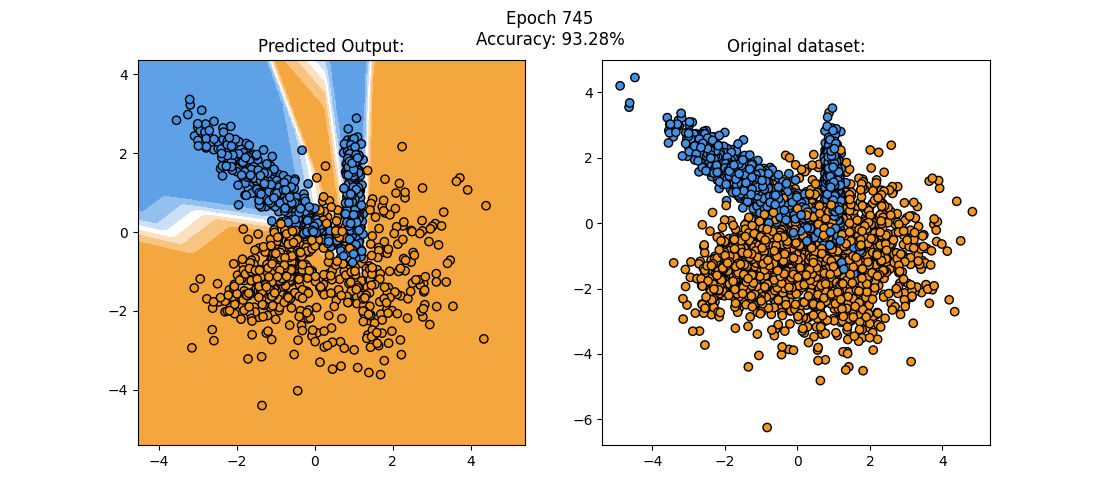

In [8]:
# Helper function for calculating accuracy
def differences(a, b):
    if len(a) != len(b):
        raise ValueError("Lists of different length.")
    return sum(i != j for i, j in zip(a, b))

# Set up the plots for visualization
global fig, ax
fig = plt.figure(figsize=(11,5))
# One subplot for the prediction and one for the dataset
ax = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax2.scatter(X[:,0], X[:,1], c=y, cmap=newcmp, marker='o', edgecolors="black")
ax2.set_title("Original dataset:")

# Fit the model on the training data. Each epoch, the callback ShowDisplayBound() is executed.
with device("CPU"):
    t_start = time.time()
    pipeline.fit(X_train, y_train)

# If show_progress is False, only visualize the final epoch
if show_progress == False:
    predicted_y = pipeline.predict(X_test)
    difference = differences(y_test, predicted_y)
    accuracy = (samples/4 - difference) / (samples/4) * 100
    ax.clear()
    DecisionBoundaryDisplay.from_estimator(pipeline, X_test, grid_resolution=100, cmap=newcmp, alpha=1, eps=0.15, ax=ax)
    ax.scatter(X_test[:,0], X_test[:,1], c=predicted_y, cmap=newcmp, marker='o', edgecolors="black")
    ax.set_title("Predicted Output:")
    fig.suptitle(f"{epochnum} Epochs\nAccuracy: {round(accuracy, 2)}%")
    display(plt.gcf())
    
clear_output()